In [1]:
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm import trange
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.utils import shuffle

In [2]:
class CNN1D(nn.Module):
    def __init__(self, number_of_categories):
        super(CNN1D, self).__init__()
        # convolution layer
        self.conv1d = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.conv1d_2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding='same')
        self.conv1d_3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same')
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(64)
        self.batch_norm_2 = nn.BatchNorm1d(128)
        self.batch_norm_3 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout1d(p=0.5)
        
        # calculate the in_features
        self.fc1 = nn.Linear(in_features=1280, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=number_of_categories)

    def forward(self, x):
        # input tensor size [batch_size, 1 (features), 40 (sequence length)]
        x = self.conv1d(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool(x)
        
        x = self.conv1d_2(x)
        x = self.batch_norm_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool(x)
        
        x = self.conv1d_3(x)
        x = self.batch_norm_3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool(x)
        
        x = x.view(-1, x.shape[1] * x.shape[2])  # Adjust the input size based on the output size after convolutions and pooling\
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [3]:
class CSIDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.int)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [4]:
def importData():
    X_train, X_val, X_test, y_train, y_val, y_test = [], [], [], [], [], []
    for i in range(10):
        temp_train = np.load(f'../data/processed_data/{i}_table_train.npy')
        temp_val = np.load(f'../data/processed_data/{i}_table_val.npy')
        temp_test = np.load(f'../data/processed_data/{i}_table_test.npy')
        if i == 0:
            X_train = temp_train
            X_val = temp_val
            X_test = temp_test
            y_train = np.array([[i] for _ in range(X_train.shape[0])])
            y_val = np.array([[i] for _ in range(X_val.shape[0])])
            y_test = np.array([[i] for _ in range(X_test.shape[0])])
        else:
            X_train = np.append(X_train, temp_train, axis=0)
            X_val = np.append(X_val, temp_val, axis=0)
            X_test = np.append(X_test, temp_test, axis=0)
            y_train = np.append(y_train, np.array([[i] for _ in range(temp_train.shape[0])]), axis=0)
            y_val = np.append(y_val, np.array([[i] for _ in range(temp_val.shape[0])]), axis=0)
            y_test = np.append(y_test, np.array([[i] for _ in range(temp_test.shape[0])]), axis=0)
            
    return X_train, X_val, X_test, y_train, y_val, y_test

In [5]:
class RunningAverage:
    def __init__(self):
        self.steps = 0
        self.total = 0

    def update(self, val):
        self.total += val
        self.steps += 1

    def __call__(self):
        return self.total / float(self.steps)

def accuracy(outputs, labels):
    # outputs (predicted), labels (true)
    outputs = np.argmax(outputs.cpu().detach().numpy(), axis=1)
    labels = labels.squeeze()
    # compare outputs with labels
    return np.sum([1 if first == second else 0 for first, second in zip(labels, outputs)]) / float(len(labels))

In [6]:
def train(model, optimizer, trainLoader, loss_fn, iterations):
    model.train()
    train_loss = RunningAverage()
    train_acc = RunningAverage()
    
    with trange(iterations) as pbar:
        for X_batch, y_batch in trainLoader:
            y_batch = y_batch.type(torch.LongTensor).squeeze(1)
            logits = model(X_batch)
            y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
            loss = loss_fn(logits, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss.update(loss)
            train_acc.update(accuracy(y_pred, y_batch))
            pbar.update(1)
            
    return train_loss(), train_acc()
    
def eval(model, valLoader, loss_fn):
    model.eval()
    eval_loss = RunningAverage()
    eval_acc = RunningAverage()
    
    with torch.no_grad():
        for X_batch, y_batch in valLoader:
            y_batch = y_batch.type(torch.LongTensor).squeeze(1)
            logits = model(X_batch)
            y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
            loss = loss_fn(logits, y_batch)
            
            eval_loss.update(loss)
            eval_acc.update(accuracy(y_pred, y_batch))
            
    return eval_loss(), eval_acc()
    
def test(model, testLoader, test_size):
    model.eval()
    for X_batch, y_batch in testLoader:
        y_batch = y_batch.type(torch.LongTensor).squeeze(1)
        logits = model(X_batch)
        y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
        
    print(f"Overall Accuracy: {accuracy(y_pred, y_batch):.3f}")

    # True positive percentage
    percentages = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
    # outputs (predicted), labels (true)
    outputs = np.argmax(y_pred.cpu().detach().numpy(), axis=1)
    labels = y_batch.squeeze()
    
    for i in range(len(outputs)):
        if outputs[i] == labels[i]:
            percentages[outputs[i]] += 1
    
    # plot the percentages of correct predictions
    y_percent = [(value/(test_size/10))*100 for key, value in percentages.items()]
    x_label = [str(key) for key, _ in percentages.items()]
    
    fig, test = plt.subplots(figsize=(10,6))
    test.bar(x_label, y_percent)
    test.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Key")
    plt.title("Accuracy (%) per key")
    plt.savefig("percentage_correct_final.png", bbox_inches='tight')
    plt.show()
    
    cm = confusion_matrix(y_true=labels, y_pred=outputs)
    cm = np.divide(cm, (test_size/10))
    
    plt.figure(figsize=(10,6))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.savefig("confusion_matrix_final.png", bbox_inches='tight')
    plt.show()
    
    print(f"Accuracy for each key: {''.join([x + ': ' + str(round(y, 3)) + '% ' for x, y in zip(x_label, y_percent)])}")
    
    print(classification_report(y_true=labels, y_pred=outputs, target_names=x_label))

In [7]:
def train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss_fn, iterations):
    # for plotting the loss and accuracy
    train_loss_list, train_acc_list, eval_loss_list, eval_acc_list  = [], [], [], []
        
    for epoch in range(epochs):
        train_loss, train_acc = train(model, optimizer, trainLoader, loss_fn, iterations)
        eval_loss, eval_acc = eval(model, valLoader, loss_fn)
        
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        eval_loss_list.append(eval_loss)
        eval_acc_list.append(eval_acc)
        
        print(f"Train: Epoch {epoch}: Loss {train_loss}, Accuracy {train_acc}")
        print(f"Eval: Epoch {epoch}: Loss {eval_loss}, Accuracy {eval_acc}")
        
    return train_loss_list, train_acc_list, eval_loss_list, eval_acc_list
        

In [8]:
def plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs):
    x = [i for i in range(1, epochs+1)]
    
    fig, loss = plt.subplots(figsize=(10,6))
    loss.plot(x, [trainLoss.item() for trainLoss in train_loss_list], label="Training Loss")
    loss.plot(x, [evalLoss.item() for evalLoss in eval_loss_list], label="Validation Loss")
    plt.legend()
    plt.ylabel("Average Loss")
    plt.xlabel("Epochs")
    plt.title("Average Loss per epoch")
    plt.savefig("loss_per_epoch_final.png", bbox_inches='tight')
    
    plt.show()
    
    fig, acc = plt.subplots(figsize=(10,6))
    acc.plot(x, [trainAcc.item() for trainAcc in train_acc_list], label="Training Accuracy")
    acc.plot(x, [evalAcc.item() for evalAcc in eval_acc_list], label="Validation Accuracy")
    plt.legend()
    plt.ylabel("Average Accuracy")
    plt.xlabel("Epochs")
    plt.title("Average Accuracy per epoch")
    plt.savefig("acc_per_epoch_final.png", bbox_inches='tight')
    plt.show()

In [9]:
def print_model_parameters(model):
    total_parameters = 0
    print(" "*20 + "Model Parameters" + " "*20)
    print("="*57)
    print(f"{'Layer':<25}" + "| Parameters")
    print("="*57)
    for name, param in model.named_parameters():
        temp = 1
        temp_list = []
        if param.requires_grad:
            print(f"{name:<25}", end="")
            for i in param.data.shape:
                temp *= i
                temp_list.append(str(i))
            print(": ", end="")
            if len(temp_list) > 1:
                print(f"{' * '.join(temp_list)}", end="")
                print(" = " + str(temp))
            else:
                print(f"{''.join(temp_list)}")

        total_parameters += temp
        
    print("="*57)
    print(f"{'Total parameters':<25}" + f": {total_parameters}")
    print("="*57)

100%|██████████| 55/55 [00:01<00:00, 37.21it/s]


Train: Epoch 0: Loss 2.329440116882324, Accuracy 0.1040289256198347
Eval: Epoch 0: Loss 2.306697368621826, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 37.52it/s]


Train: Epoch 1: Loss 2.317922592163086, Accuracy 0.09989669421487603
Eval: Epoch 1: Loss 2.305565357208252, Accuracy 0.094140625


100%|██████████| 55/55 [00:01<00:00, 34.99it/s]


Train: Epoch 2: Loss 2.3161513805389404, Accuracy 0.10542355371900826
Eval: Epoch 2: Loss 2.305398941040039, Accuracy 0.094140625


100%|██████████| 55/55 [00:01<00:00, 39.26it/s]


Train: Epoch 3: Loss 2.3110198974609375, Accuracy 0.09509297520661157
Eval: Epoch 3: Loss 2.3057992458343506, Accuracy 0.0888671875


100%|██████████| 55/55 [00:01<00:00, 39.86it/s]


Train: Epoch 4: Loss 2.3100383281707764, Accuracy 0.10149793388429751
Eval: Epoch 4: Loss 2.305983781814575, Accuracy 0.09296875


100%|██████████| 55/55 [00:01<00:00, 39.31it/s]


Train: Epoch 5: Loss 2.309551954269409, Accuracy 0.10389979338842976
Eval: Epoch 5: Loss 2.3052361011505127, Accuracy 0.090625


100%|██████████| 55/55 [00:01<00:00, 40.18it/s]


Train: Epoch 6: Loss 2.302952289581299, Accuracy 0.11162190082644628
Eval: Epoch 6: Loss 2.305417537689209, Accuracy 0.0857421875


100%|██████████| 55/55 [00:01<00:00, 38.79it/s]


Train: Epoch 7: Loss 2.3052101135253906, Accuracy 0.10395144628099175
Eval: Epoch 7: Loss 2.304344892501831, Accuracy 0.10234375


100%|██████████| 55/55 [00:01<00:00, 39.17it/s]


Train: Epoch 8: Loss 2.3067312240600586, Accuracy 0.09894111570247933
Eval: Epoch 8: Loss 2.3043689727783203, Accuracy 0.1046875


100%|██████████| 55/55 [00:01<00:00, 39.91it/s]


Train: Epoch 9: Loss 2.306126356124878, Accuracy 0.10666322314049587
Eval: Epoch 9: Loss 2.3029866218566895, Accuracy 0.09765625


100%|██████████| 55/55 [00:01<00:00, 39.68it/s]


Train: Epoch 10: Loss 2.306412935256958, Accuracy 0.1090392561983471
Eval: Epoch 10: Loss 2.3036561012268066, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 37.75it/s]


Train: Epoch 11: Loss 2.3013131618499756, Accuracy 0.11185433884297522
Eval: Epoch 11: Loss 2.303922653198242, Accuracy 0.0904296875


100%|██████████| 55/55 [00:01<00:00, 38.98it/s]


Train: Epoch 12: Loss 2.303067922592163, Accuracy 0.10519111570247933
Eval: Epoch 12: Loss 2.303950309753418, Accuracy 0.0998046875


100%|██████████| 55/55 [00:01<00:00, 39.06it/s]


Train: Epoch 13: Loss 2.3009111881256104, Accuracy 0.11681301652892562
Eval: Epoch 13: Loss 2.30338191986084, Accuracy 0.0982421875


100%|██████████| 55/55 [00:01<00:00, 39.45it/s]


Train: Epoch 14: Loss 2.3042004108428955, Accuracy 0.10676652892561983
Eval: Epoch 14: Loss 2.3036601543426514, Accuracy 0.0984375


100%|██████████| 55/55 [00:01<00:00, 39.12it/s]


Train: Epoch 15: Loss 2.300865650177002, Accuracy 0.11159607438016529
Eval: Epoch 15: Loss 2.3032894134521484, Accuracy 0.0890625


100%|██████████| 55/55 [00:01<00:00, 39.54it/s]


Train: Epoch 16: Loss 2.300623893737793, Accuracy 0.11027892561983471
Eval: Epoch 16: Loss 2.302654266357422, Accuracy 0.096484375


100%|██████████| 55/55 [00:01<00:00, 38.14it/s]


Train: Epoch 17: Loss 2.300313949584961, Accuracy 0.11234504132231404
Eval: Epoch 17: Loss 2.302550792694092, Accuracy 0.1005859375


100%|██████████| 55/55 [00:01<00:00, 39.17it/s]


Train: Epoch 18: Loss 2.3012707233428955, Accuracy 0.11133780991735538
Eval: Epoch 18: Loss 2.302943468093872, Accuracy 0.1041015625


100%|██████████| 55/55 [00:01<00:00, 38.09it/s]


Train: Epoch 19: Loss 2.302759885787964, Accuracy 0.11327479338842976
Eval: Epoch 19: Loss 2.30308198928833, Accuracy 0.1013671875


100%|██████████| 55/55 [00:01<00:00, 39.45it/s]


Train: Epoch 20: Loss 2.3002243041992188, Accuracy 0.09994834710743801
Eval: Epoch 20: Loss 2.3034884929656982, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 38.76it/s]


Train: Epoch 21: Loss 2.3020811080932617, Accuracy 0.11286157024793388
Eval: Epoch 21: Loss 2.3037049770355225, Accuracy 0.0908203125


100%|██████████| 55/55 [00:01<00:00, 38.98it/s]


Train: Epoch 22: Loss 2.299306869506836, Accuracy 0.11425619834710744
Eval: Epoch 22: Loss 2.3042068481445312, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 38.87it/s]


Train: Epoch 23: Loss 2.297443151473999, Accuracy 0.12107438016528926
Eval: Epoch 23: Loss 2.303654670715332, Accuracy 0.090625


100%|██████████| 55/55 [00:01<00:00, 39.80it/s]


Train: Epoch 24: Loss 2.3008463382720947, Accuracy 0.10606921487603306
Eval: Epoch 24: Loss 2.303454875946045, Accuracy 0.0919921875


100%|██████████| 55/55 [00:01<00:00, 38.09it/s]


Train: Epoch 25: Loss 2.302412271499634, Accuracy 0.1024793388429752
Eval: Epoch 25: Loss 2.3036715984344482, Accuracy 0.0853515625


100%|██████████| 55/55 [00:01<00:00, 39.23it/s]


Train: Epoch 26: Loss 2.2972567081451416, Accuracy 0.11301652892561984
Eval: Epoch 26: Loss 2.3039653301239014, Accuracy 0.0830078125


100%|██████████| 55/55 [00:01<00:00, 39.74it/s]


Train: Epoch 27: Loss 2.2966628074645996, Accuracy 0.11637396694214876
Eval: Epoch 27: Loss 2.30429744720459, Accuracy 0.082421875


100%|██████████| 55/55 [00:01<00:00, 38.19it/s]


Train: Epoch 28: Loss 2.295971632003784, Accuracy 0.11996384297520661
Eval: Epoch 28: Loss 2.304302215576172, Accuracy 0.08046875


100%|██████████| 55/55 [00:01<00:00, 40.03it/s]


Train: Epoch 29: Loss 2.2968921661376953, Accuracy 0.12197830578512397
Eval: Epoch 29: Loss 2.3046648502349854, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 38.62it/s]


Train: Epoch 30: Loss 2.299565315246582, Accuracy 0.10973657024793387
Eval: Epoch 30: Loss 2.304957628250122, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 40.09it/s]


Train: Epoch 31: Loss 2.296525478363037, Accuracy 0.1153150826446281
Eval: Epoch 31: Loss 2.30497145652771, Accuracy 0.1046875


100%|██████████| 55/55 [00:01<00:00, 38.65it/s]


Train: Epoch 32: Loss 2.294203996658325, Accuracy 0.12040289256198347
Eval: Epoch 32: Loss 2.3046250343322754, Accuracy 0.1091796875


100%|██████████| 55/55 [00:01<00:00, 38.57it/s]


Train: Epoch 33: Loss 2.297386884689331, Accuracy 0.11547004132231405
Eval: Epoch 33: Loss 2.3043458461761475, Accuracy 0.10625


100%|██████████| 55/55 [00:01<00:00, 39.97it/s]


Train: Epoch 34: Loss 2.2936365604400635, Accuracy 0.12554235537190084
Eval: Epoch 34: Loss 2.3042969703674316, Accuracy 0.103515625


100%|██████████| 55/55 [00:01<00:00, 38.84it/s]


Train: Epoch 35: Loss 2.2937915325164795, Accuracy 0.12120351239669422
Eval: Epoch 35: Loss 2.3049521446228027, Accuracy 0.1033203125


100%|██████████| 55/55 [00:01<00:00, 38.76it/s]


Train: Epoch 36: Loss 2.29384708404541, Accuracy 0.1261880165289256
Eval: Epoch 36: Loss 2.305159568786621, Accuracy 0.10703125


100%|██████████| 55/55 [00:01<00:00, 39.43it/s]


Train: Epoch 37: Loss 2.296313524246216, Accuracy 0.11686466942148761
Eval: Epoch 37: Loss 2.306450843811035, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 38.38it/s]


Train: Epoch 38: Loss 2.2921721935272217, Accuracy 0.1231404958677686
Eval: Epoch 38: Loss 2.3048110008239746, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 39.51it/s]


Train: Epoch 39: Loss 2.292520761489868, Accuracy 0.12254648760330579
Eval: Epoch 39: Loss 2.305772066116333, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 39.17it/s]


Train: Epoch 40: Loss 2.295400619506836, Accuracy 0.11665805785123967
Eval: Epoch 40: Loss 2.30713152885437, Accuracy 0.0880859375


100%|██████████| 55/55 [00:01<00:00, 38.19it/s]


Train: Epoch 41: Loss 2.294501304626465, Accuracy 0.12166838842975206
Eval: Epoch 41: Loss 2.3069138526916504, Accuracy 0.0892578125


100%|██████████| 55/55 [00:01<00:00, 39.01it/s]


Train: Epoch 42: Loss 2.293016195297241, Accuracy 0.12675619834710744
Eval: Epoch 42: Loss 2.307354688644409, Accuracy 0.087890625


100%|██████████| 55/55 [00:01<00:00, 37.98it/s]


Train: Epoch 43: Loss 2.2880167961120605, Accuracy 0.131301652892562
Eval: Epoch 43: Loss 2.3066036701202393, Accuracy 0.095703125


100%|██████████| 55/55 [00:01<00:00, 39.45it/s]


Train: Epoch 44: Loss 2.291179895401001, Accuracy 0.12151342975206612
Eval: Epoch 44: Loss 2.307386875152588, Accuracy 0.088671875


100%|██████████| 55/55 [00:01<00:00, 39.43it/s]


Train: Epoch 45: Loss 2.289128065109253, Accuracy 0.13442665289256198
Eval: Epoch 45: Loss 2.306731939315796, Accuracy 0.09921875


100%|██████████| 55/55 [00:01<00:00, 39.17it/s]


Train: Epoch 46: Loss 2.287524938583374, Accuracy 0.13215392561983472
Eval: Epoch 46: Loss 2.309277057647705, Accuracy 0.0919921875


100%|██████████| 55/55 [00:01<00:00, 38.71it/s]


Train: Epoch 47: Loss 2.287659168243408, Accuracy 0.12352789256198347
Eval: Epoch 47: Loss 2.308711051940918, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 39.20it/s]


Train: Epoch 48: Loss 2.289294958114624, Accuracy 0.1277892561983471
Eval: Epoch 48: Loss 2.3090319633483887, Accuracy 0.0837890625


100%|██████████| 55/55 [00:01<00:00, 38.57it/s]


Train: Epoch 49: Loss 2.286912202835083, Accuracy 0.1334452479338843
Eval: Epoch 49: Loss 2.3085007667541504, Accuracy 0.090234375


100%|██████████| 55/55 [00:01<00:00, 38.60it/s]


Train: Epoch 50: Loss 2.2903401851654053, Accuracy 0.12182334710743802
Eval: Epoch 50: Loss 2.3078255653381348, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 38.90it/s]


Train: Epoch 51: Loss 2.2874104976654053, Accuracy 0.13132747933884298
Eval: Epoch 51: Loss 2.3088700771331787, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 39.48it/s]


Train: Epoch 52: Loss 2.2859227657318115, Accuracy 0.13357438016528925
Eval: Epoch 52: Loss 2.3086740970611572, Accuracy 0.1001953125


100%|██████████| 55/55 [00:01<00:00, 38.98it/s]


Train: Epoch 53: Loss 2.2823798656463623, Accuracy 0.1327479338842975
Eval: Epoch 53: Loss 2.3111679553985596, Accuracy 0.0953125


100%|██████████| 55/55 [00:01<00:00, 39.15it/s]


Train: Epoch 54: Loss 2.287191390991211, Accuracy 0.1334194214876033
Eval: Epoch 54: Loss 2.3108956813812256, Accuracy 0.084375


100%|██████████| 55/55 [00:01<00:00, 39.48it/s]


Train: Epoch 55: Loss 2.2844748497009277, Accuracy 0.1391270661157025
Eval: Epoch 55: Loss 2.3111658096313477, Accuracy 0.090625


100%|██████████| 55/55 [00:01<00:00, 39.20it/s]


Train: Epoch 56: Loss 2.283933162689209, Accuracy 0.12760847107438017
Eval: Epoch 56: Loss 2.3118274211883545, Accuracy 0.09609375


100%|██████████| 55/55 [00:01<00:00, 38.43it/s]


Train: Epoch 57: Loss 2.2839460372924805, Accuracy 0.13610537190082644
Eval: Epoch 57: Loss 2.3106935024261475, Accuracy 0.09453125


100%|██████████| 55/55 [00:01<00:00, 39.29it/s]


Train: Epoch 58: Loss 2.2834763526916504, Accuracy 0.13360020661157024
Eval: Epoch 58: Loss 2.3123130798339844, Accuracy 0.083203125


100%|██████████| 55/55 [00:01<00:00, 39.01it/s]


Train: Epoch 59: Loss 2.2821545600891113, Accuracy 0.1365444214876033
Eval: Epoch 59: Loss 2.312058925628662, Accuracy 0.09609375


100%|██████████| 55/55 [00:01<00:00, 39.34it/s]


Train: Epoch 60: Loss 2.2783284187316895, Accuracy 0.1378357438016529
Eval: Epoch 60: Loss 2.311978578567505, Accuracy 0.08515625


100%|██████████| 55/55 [00:01<00:00, 38.38it/s]


Train: Epoch 61: Loss 2.2800774574279785, Accuracy 0.13398760330578513
Eval: Epoch 61: Loss 2.3119900226593018, Accuracy 0.0908203125


100%|██████████| 55/55 [00:01<00:00, 38.65it/s]


Train: Epoch 62: Loss 2.278374671936035, Accuracy 0.137448347107438
Eval: Epoch 62: Loss 2.3133785724639893, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 38.95it/s]


Train: Epoch 63: Loss 2.277911901473999, Accuracy 0.15010330578512396
Eval: Epoch 63: Loss 2.3131837844848633, Accuracy 0.0904296875


100%|██████████| 55/55 [00:01<00:00, 39.57it/s]


Train: Epoch 64: Loss 2.2784132957458496, Accuracy 0.14553202479338842
Eval: Epoch 64: Loss 2.313149929046631, Accuracy 0.0865234375


100%|██████████| 55/55 [00:01<00:00, 39.85it/s]


Train: Epoch 65: Loss 2.2765421867370605, Accuracy 0.1368543388429752
Eval: Epoch 65: Loss 2.313260316848755, Accuracy 0.0947265625


100%|██████████| 55/55 [00:01<00:00, 38.49it/s]


Train: Epoch 66: Loss 2.2764203548431396, Accuracy 0.13517561983471074
Eval: Epoch 66: Loss 2.313978433609009, Accuracy 0.0984375


100%|██████████| 55/55 [00:01<00:00, 38.95it/s]


Train: Epoch 67: Loss 2.2774405479431152, Accuracy 0.1449121900826446
Eval: Epoch 67: Loss 2.3154916763305664, Accuracy 0.090234375


100%|██████████| 55/55 [00:01<00:00, 39.43it/s]


Train: Epoch 68: Loss 2.2711093425750732, Accuracy 0.14168388429752066
Eval: Epoch 68: Loss 2.3145956993103027, Accuracy 0.1001953125


100%|██████████| 55/55 [00:01<00:00, 37.96it/s]


Train: Epoch 69: Loss 2.2756094932556152, Accuracy 0.14142561983471075
Eval: Epoch 69: Loss 2.316206216812134, Accuracy 0.0916015625


100%|██████████| 55/55 [00:01<00:00, 38.92it/s]


Train: Epoch 70: Loss 2.2727479934692383, Accuracy 0.1412448347107438
Eval: Epoch 70: Loss 2.3143136501312256, Accuracy 0.0943359375


100%|██████████| 55/55 [00:01<00:00, 39.26it/s]


Train: Epoch 71: Loss 2.2721097469329834, Accuracy 0.1394111570247934
Eval: Epoch 71: Loss 2.315622091293335, Accuracy 0.0884765625


100%|██████████| 55/55 [00:01<00:00, 38.81it/s]


Train: Epoch 72: Loss 2.264791488647461, Accuracy 0.15116219008264464
Eval: Epoch 72: Loss 2.31897234916687, Accuracy 0.0873046875


100%|██████████| 55/55 [00:01<00:00, 38.87it/s]


Train: Epoch 73: Loss 2.267488479614258, Accuracy 0.1450154958677686
Eval: Epoch 73: Loss 2.3187544345855713, Accuracy 0.0830078125


100%|██████████| 55/55 [00:01<00:00, 39.02it/s]


Train: Epoch 74: Loss 2.2690231800079346, Accuracy 0.14426652892561984
Eval: Epoch 74: Loss 2.3182713985443115, Accuracy 0.08359375


100%|██████████| 55/55 [00:01<00:00, 38.73it/s]


Train: Epoch 75: Loss 2.2667322158813477, Accuracy 0.15655991735537192
Eval: Epoch 75: Loss 2.31833553314209, Accuracy 0.0927734375


100%|██████████| 55/55 [00:01<00:00, 38.73it/s]


Train: Epoch 76: Loss 2.265648365020752, Accuracy 0.14702995867768595
Eval: Epoch 76: Loss 2.3175361156463623, Accuracy 0.0873046875


100%|██████████| 55/55 [00:01<00:00, 39.63it/s]


Train: Epoch 77: Loss 2.2654805183410645, Accuracy 0.14635847107438016
Eval: Epoch 77: Loss 2.3199424743652344, Accuracy 0.0841796875


100%|██████████| 55/55 [00:01<00:00, 38.79it/s]


Train: Epoch 78: Loss 2.2644896507263184, Accuracy 0.14881198347107438
Eval: Epoch 78: Loss 2.318770170211792, Accuracy 0.08984375


100%|██████████| 55/55 [00:01<00:00, 39.03it/s]


Train: Epoch 79: Loss 2.2597572803497314, Accuracy 0.1565082644628099
Eval: Epoch 79: Loss 2.320028305053711, Accuracy 0.08203125


100%|██████████| 55/55 [00:01<00:00, 38.33it/s]


Train: Epoch 80: Loss 2.2579596042633057, Accuracy 0.16009814049586776
Eval: Epoch 80: Loss 2.324854612350464, Accuracy 0.083984375


100%|██████████| 55/55 [00:01<00:00, 39.01it/s]


Train: Epoch 81: Loss 2.2608697414398193, Accuracy 0.15361570247933884
Eval: Epoch 81: Loss 2.322045087814331, Accuracy 0.075


100%|██████████| 55/55 [00:01<00:00, 36.29it/s]


Train: Epoch 82: Loss 2.2573494911193848, Accuracy 0.1509297520661157
Eval: Epoch 82: Loss 2.326148509979248, Accuracy 0.0875


100%|██████████| 55/55 [00:01<00:00, 39.03it/s]


Train: Epoch 83: Loss 2.2576215267181396, Accuracy 0.15105888429752068
Eval: Epoch 83: Loss 2.3263256549835205, Accuracy 0.0818359375


100%|██████████| 55/55 [00:01<00:00, 38.43it/s]


Train: Epoch 84: Loss 2.251596689224243, Accuracy 0.1581353305785124
Eval: Epoch 84: Loss 2.3251450061798096, Accuracy 0.0759765625


100%|██████████| 55/55 [00:01<00:00, 38.06it/s]


Train: Epoch 85: Loss 2.2550323009490967, Accuracy 0.16012396694214875
Eval: Epoch 85: Loss 2.326775550842285, Accuracy 0.0845703125


100%|██████████| 55/55 [00:01<00:00, 39.40it/s]


Train: Epoch 86: Loss 2.2541146278381348, Accuracy 0.1555785123966942
Eval: Epoch 86: Loss 2.328479051589966, Accuracy 0.0818359375


100%|██████████| 55/55 [00:01<00:00, 39.26it/s]


Train: Epoch 87: Loss 2.254399061203003, Accuracy 0.149974173553719
Eval: Epoch 87: Loss 2.3263299465179443, Accuracy 0.0853515625


100%|██████████| 55/55 [00:01<00:00, 38.49it/s]


Train: Epoch 88: Loss 2.25193190574646, Accuracy 0.15588842975206613
Eval: Epoch 88: Loss 2.326848030090332, Accuracy 0.0853515625


100%|██████████| 55/55 [00:01<00:00, 39.29it/s]


Train: Epoch 89: Loss 2.2483067512512207, Accuracy 0.16766528925619834
Eval: Epoch 89: Loss 2.3303334712982178, Accuracy 0.07890625


100%|██████████| 55/55 [00:01<00:00, 38.65it/s]


Train: Epoch 90: Loss 2.250662326812744, Accuracy 0.16771694214876035
Eval: Epoch 90: Loss 2.3310561180114746, Accuracy 0.0802734375


100%|██████████| 55/55 [00:01<00:00, 39.06it/s]


Train: Epoch 91: Loss 2.248351812362671, Accuracy 0.1641270661157025
Eval: Epoch 91: Loss 2.333876371383667, Accuracy 0.0802734375


100%|██████████| 55/55 [00:01<00:00, 38.79it/s]


Train: Epoch 92: Loss 2.247649908065796, Accuracy 0.16696797520661158
Eval: Epoch 92: Loss 2.3339414596557617, Accuracy 0.0794921875


100%|██████████| 55/55 [00:01<00:00, 38.81it/s]


Train: Epoch 93: Loss 2.2530226707458496, Accuracy 0.1524276859504132
Eval: Epoch 93: Loss 2.332217216491699, Accuracy 0.0802734375


100%|██████████| 55/55 [00:01<00:00, 38.79it/s]


Train: Epoch 94: Loss 2.242490768432617, Accuracy 0.16962809917355373
Eval: Epoch 94: Loss 2.3323824405670166, Accuracy 0.0787109375


100%|██████████| 55/55 [00:01<00:00, 39.43it/s]


Train: Epoch 95: Loss 2.2445459365844727, Accuracy 0.1697314049586777
Eval: Epoch 95: Loss 2.335820436477661, Accuracy 0.08515625


100%|██████████| 55/55 [00:01<00:00, 37.26it/s]


Train: Epoch 96: Loss 2.238626480102539, Accuracy 0.17053202479338841
Eval: Epoch 96: Loss 2.333806276321411, Accuracy 0.094921875


100%|██████████| 55/55 [00:01<00:00, 34.23it/s]


Train: Epoch 97: Loss 2.240109920501709, Accuracy 0.1668904958677686
Eval: Epoch 97: Loss 2.334717273712158, Accuracy 0.0919921875


100%|██████████| 55/55 [00:01<00:00, 35.05it/s]


Train: Epoch 98: Loss 2.240035057067871, Accuracy 0.16753615702479338
Eval: Epoch 98: Loss 2.33526873588562, Accuracy 0.08515625


100%|██████████| 55/55 [00:01<00:00, 34.57it/s]


Train: Epoch 99: Loss 2.236280918121338, Accuracy 0.1737603305785124
Eval: Epoch 99: Loss 2.3394792079925537, Accuracy 0.0841796875


100%|██████████| 55/55 [00:01<00:00, 34.10it/s]


Train: Epoch 100: Loss 2.238246202468872, Accuracy 0.17081611570247934
Eval: Epoch 100: Loss 2.3396482467651367, Accuracy 0.0880859375


100%|██████████| 55/55 [00:01<00:00, 34.72it/s]


Train: Epoch 101: Loss 2.234576940536499, Accuracy 0.1696539256198347
Eval: Epoch 101: Loss 2.340458393096924, Accuracy 0.087109375


100%|██████████| 55/55 [00:01<00:00, 35.21it/s]


Train: Epoch 102: Loss 2.2344038486480713, Accuracy 0.1730888429752066
Eval: Epoch 102: Loss 2.3425872325897217, Accuracy 0.0853515625


100%|██████████| 55/55 [00:01<00:00, 31.37it/s]


Train: Epoch 103: Loss 2.2307450771331787, Accuracy 0.1803202479338843
Eval: Epoch 103: Loss 2.3428761959075928, Accuracy 0.0890625


100%|██████████| 55/55 [00:01<00:00, 33.85it/s]


Train: Epoch 104: Loss 2.2307193279266357, Accuracy 0.17221074380165288
Eval: Epoch 104: Loss 2.343763589859009, Accuracy 0.0875


100%|██████████| 55/55 [00:01<00:00, 35.58it/s]


Train: Epoch 105: Loss 2.2264649868011475, Accuracy 0.17998450413223138
Eval: Epoch 105: Loss 2.3452577590942383, Accuracy 0.0890625


100%|██████████| 55/55 [00:01<00:00, 35.19it/s]


Train: Epoch 106: Loss 2.22819185256958, Accuracy 0.17603305785123965
Eval: Epoch 106: Loss 2.344573974609375, Accuracy 0.08984375


100%|██████████| 55/55 [00:01<00:00, 35.51it/s]


Train: Epoch 107: Loss 2.2336983680725098, Accuracy 0.1684917355371901
Eval: Epoch 107: Loss 2.3447821140289307, Accuracy 0.0857421875


100%|██████████| 55/55 [00:01<00:00, 35.74it/s]


Train: Epoch 108: Loss 2.2289092540740967, Accuracy 0.1730888429752066
Eval: Epoch 108: Loss 2.3457703590393066, Accuracy 0.0818359375


100%|██████████| 55/55 [00:01<00:00, 35.64it/s]


Train: Epoch 109: Loss 2.223221778869629, Accuracy 0.17422520661157023
Eval: Epoch 109: Loss 2.343689441680908, Accuracy 0.084375


100%|██████████| 55/55 [00:01<00:00, 35.44it/s]


Train: Epoch 110: Loss 2.2188780307769775, Accuracy 0.18202479338842975
Eval: Epoch 110: Loss 2.3438096046447754, Accuracy 0.081640625


100%|██████████| 55/55 [00:01<00:00, 35.60it/s]


Train: Epoch 111: Loss 2.2225868701934814, Accuracy 0.17662706611570247
Eval: Epoch 111: Loss 2.345850706100464, Accuracy 0.0892578125


100%|██████████| 55/55 [00:01<00:00, 35.03it/s]


Train: Epoch 112: Loss 2.2147631645202637, Accuracy 0.18819731404958678
Eval: Epoch 112: Loss 2.35084867477417, Accuracy 0.0890625


100%|██████████| 55/55 [00:01<00:00, 35.46it/s]


Train: Epoch 113: Loss 2.2179126739501953, Accuracy 0.19323347107438016
Eval: Epoch 113: Loss 2.351381540298462, Accuracy 0.0919921875


100%|██████████| 55/55 [00:01<00:00, 35.17it/s]


Train: Epoch 114: Loss 2.2156782150268555, Accuracy 0.19560950413223138
Eval: Epoch 114: Loss 2.3472671508789062, Accuracy 0.0982421875


100%|██████████| 55/55 [00:01<00:00, 33.15it/s]


Train: Epoch 115: Loss 2.2166712284088135, Accuracy 0.1909349173553719
Eval: Epoch 115: Loss 2.347498655319214, Accuracy 0.0947265625


100%|██████████| 55/55 [00:01<00:00, 35.61it/s]


Train: Epoch 116: Loss 2.215958595275879, Accuracy 0.1862345041322314
Eval: Epoch 116: Loss 2.3501720428466797, Accuracy 0.086328125


100%|██████████| 55/55 [00:01<00:00, 35.62it/s]


Train: Epoch 117: Loss 2.2134485244750977, Accuracy 0.19225206611570247
Eval: Epoch 117: Loss 2.3517963886260986, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 34.48it/s]


Train: Epoch 118: Loss 2.2090325355529785, Accuracy 0.19165805785123965
Eval: Epoch 118: Loss 2.353071689605713, Accuracy 0.0921875


100%|██████████| 55/55 [00:01<00:00, 35.14it/s]


Train: Epoch 119: Loss 2.2095863819122314, Accuracy 0.19199380165289257
Eval: Epoch 119: Loss 2.3558876514434814, Accuracy 0.084375


100%|██████████| 55/55 [00:01<00:00, 34.77it/s]


Train: Epoch 120: Loss 2.2077527046203613, Accuracy 0.19207128099173554
Eval: Epoch 120: Loss 2.354055643081665, Accuracy 0.0908203125


100%|██████████| 55/55 [00:01<00:00, 35.72it/s]


Train: Epoch 121: Loss 2.2052838802337646, Accuracy 0.1915289256198347
Eval: Epoch 121: Loss 2.3565001487731934, Accuracy 0.09453125


100%|██████████| 55/55 [00:01<00:00, 35.42it/s]


Train: Epoch 122: Loss 2.2063066959381104, Accuracy 0.19715909090909092
Eval: Epoch 122: Loss 2.3552167415618896, Accuracy 0.0884765625


100%|██████████| 55/55 [00:01<00:00, 35.14it/s]


Train: Epoch 123: Loss 2.200028896331787, Accuracy 0.20116219008264463
Eval: Epoch 123: Loss 2.360037088394165, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 35.73it/s]


Train: Epoch 124: Loss 2.204077959060669, Accuracy 0.1940340909090909
Eval: Epoch 124: Loss 2.3573734760284424, Accuracy 0.0986328125


100%|██████████| 55/55 [00:01<00:00, 34.79it/s]


Train: Epoch 125: Loss 2.1998324394226074, Accuracy 0.1964617768595041
Eval: Epoch 125: Loss 2.361250162124634, Accuracy 0.0912109375


100%|██████████| 55/55 [00:01<00:00, 35.12it/s]


Train: Epoch 126: Loss 2.1921634674072266, Accuracy 0.20426136363636363
Eval: Epoch 126: Loss 2.3633501529693604, Accuracy 0.089453125


100%|██████████| 55/55 [00:01<00:00, 34.61it/s]


Train: Epoch 127: Loss 2.1971397399902344, Accuracy 0.19976756198347106
Eval: Epoch 127: Loss 2.361210346221924, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 34.79it/s]


Train: Epoch 128: Loss 2.1887660026550293, Accuracy 0.20271177685950412
Eval: Epoch 128: Loss 2.3614046573638916, Accuracy 0.0998046875


100%|██████████| 55/55 [00:01<00:00, 35.12it/s]


Train: Epoch 129: Loss 2.1917872428894043, Accuracy 0.20764462809917356
Eval: Epoch 129: Loss 2.362942934036255, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 34.62it/s]


Train: Epoch 130: Loss 2.188896417617798, Accuracy 0.2021694214876033
Eval: Epoch 130: Loss 2.360581874847412, Accuracy 0.0921875


100%|██████████| 55/55 [00:01<00:00, 32.43it/s]


Train: Epoch 131: Loss 2.191209554672241, Accuracy 0.19772727272727272
Eval: Epoch 131: Loss 2.3632090091705322, Accuracy 0.09140625


100%|██████████| 55/55 [00:01<00:00, 33.77it/s]


Train: Epoch 132: Loss 2.190763235092163, Accuracy 0.1993801652892562
Eval: Epoch 132: Loss 2.362987518310547, Accuracy 0.0966796875


100%|██████████| 55/55 [00:01<00:00, 33.85it/s]


Train: Epoch 133: Loss 2.183086633682251, Accuracy 0.20914256198347106
Eval: Epoch 133: Loss 2.3650918006896973, Accuracy 0.0919921875


100%|██████████| 55/55 [00:01<00:00, 34.79it/s]


Train: Epoch 134: Loss 2.179933786392212, Accuracy 0.20470041322314048
Eval: Epoch 134: Loss 2.3686399459838867, Accuracy 0.088671875


100%|██████████| 55/55 [00:01<00:00, 34.87it/s]


Train: Epoch 135: Loss 2.1817097663879395, Accuracy 0.21113119834710742
Eval: Epoch 135: Loss 2.3700857162475586, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 35.28it/s]


Train: Epoch 136: Loss 2.1835384368896484, Accuracy 0.20570764462809918
Eval: Epoch 136: Loss 2.366729259490967, Accuracy 0.09609375


100%|██████████| 55/55 [00:01<00:00, 35.29it/s]


Train: Epoch 137: Loss 2.1779704093933105, Accuracy 0.20759297520661157
Eval: Epoch 137: Loss 2.3689258098602295, Accuracy 0.094140625


100%|██████████| 55/55 [00:01<00:00, 34.84it/s]


Train: Epoch 138: Loss 2.178734064102173, Accuracy 0.20759297520661157
Eval: Epoch 138: Loss 2.368159055709839, Accuracy 0.0880859375


100%|██████████| 55/55 [00:01<00:00, 35.08it/s]


Train: Epoch 139: Loss 2.175708532333374, Accuracy 0.2071539256198347
Eval: Epoch 139: Loss 2.369739532470703, Accuracy 0.09296875


100%|██████████| 55/55 [00:01<00:00, 34.94it/s]


Train: Epoch 140: Loss 2.171104907989502, Accuracy 0.20614669421487603
Eval: Epoch 140: Loss 2.371988296508789, Accuracy 0.0927734375


100%|██████████| 55/55 [00:01<00:00, 34.72it/s]


Train: Epoch 141: Loss 2.1709601879119873, Accuracy 0.20798037190082647
Eval: Epoch 141: Loss 2.3738319873809814, Accuracy 0.092578125


100%|██████████| 55/55 [00:01<00:00, 34.79it/s]


Train: Epoch 142: Loss 2.1774368286132812, Accuracy 0.21097623966942147
Eval: Epoch 142: Loss 2.3772542476654053, Accuracy 0.090625


100%|██████████| 55/55 [00:01<00:00, 34.72it/s]


Train: Epoch 143: Loss 2.16630482673645, Accuracy 0.21014979338842976
Eval: Epoch 143: Loss 2.3791370391845703, Accuracy 0.0916015625


100%|██████████| 55/55 [00:01<00:00, 34.61it/s]


Train: Epoch 144: Loss 2.163398027420044, Accuracy 0.2102789256198347
Eval: Epoch 144: Loss 2.379067897796631, Accuracy 0.09921875


100%|██████████| 55/55 [00:01<00:00, 35.44it/s]


Train: Epoch 145: Loss 2.1636791229248047, Accuracy 0.22019628099173555
Eval: Epoch 145: Loss 2.3755593299865723, Accuracy 0.0939453125


100%|██████████| 55/55 [00:01<00:00, 35.42it/s]


Train: Epoch 146: Loss 2.165630340576172, Accuracy 0.21947314049586775
Eval: Epoch 146: Loss 2.3777077198028564, Accuracy 0.0919921875


100%|██████████| 55/55 [00:01<00:00, 34.92it/s]


Train: Epoch 147: Loss 2.1616978645324707, Accuracy 0.20457128099173555
Eval: Epoch 147: Loss 2.3815290927886963, Accuracy 0.0880859375


100%|██████████| 55/55 [00:01<00:00, 34.15it/s]


Train: Epoch 148: Loss 2.158186674118042, Accuracy 0.22709194214876033
Eval: Epoch 148: Loss 2.3808202743530273, Accuracy 0.086328125


100%|██████████| 55/55 [00:01<00:00, 35.03it/s]


Train: Epoch 149: Loss 2.1551311016082764, Accuracy 0.21580578512396695
Eval: Epoch 149: Loss 2.381924629211426, Accuracy 0.09375


100%|██████████| 55/55 [00:01<00:00, 35.07it/s]


Train: Epoch 150: Loss 2.1550354957580566, Accuracy 0.2166064049586777
Eval: Epoch 150: Loss 2.379530668258667, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 35.42it/s]


Train: Epoch 151: Loss 2.143494129180908, Accuracy 0.2141012396694215
Eval: Epoch 151: Loss 2.3833298683166504, Accuracy 0.0890625


100%|██████████| 55/55 [00:01<00:00, 34.55it/s]


Train: Epoch 152: Loss 2.155545234680176, Accuracy 0.22518078512396694
Eval: Epoch 152: Loss 2.3807268142700195, Accuracy 0.0947265625


100%|██████████| 55/55 [00:01<00:00, 34.22it/s]


Train: Epoch 153: Loss 2.1465647220611572, Accuracy 0.22758264462809918
Eval: Epoch 153: Loss 2.3837006092071533, Accuracy 0.09375


100%|██████████| 55/55 [00:01<00:00, 35.35it/s]


Train: Epoch 154: Loss 2.1531612873077393, Accuracy 0.22146177685950413
Eval: Epoch 154: Loss 2.3873345851898193, Accuracy 0.093359375


100%|██████████| 55/55 [00:01<00:00, 34.22it/s]


Train: Epoch 155: Loss 2.144040107727051, Accuracy 0.22295971074380166
Eval: Epoch 155: Loss 2.3881633281707764, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 35.46it/s]


Train: Epoch 156: Loss 2.1381568908691406, Accuracy 0.23331611570247934
Eval: Epoch 156: Loss 2.3839008808135986, Accuracy 0.095703125


100%|██████████| 55/55 [00:01<00:00, 35.28it/s]


Train: Epoch 157: Loss 2.1417927742004395, Accuracy 0.23052685950413224
Eval: Epoch 157: Loss 2.3910210132598877, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 34.96it/s]


Train: Epoch 158: Loss 2.136944055557251, Accuracy 0.2266270661157025
Eval: Epoch 158: Loss 2.393609046936035, Accuracy 0.0966796875


100%|██████████| 55/55 [00:01<00:00, 34.20it/s]


Train: Epoch 159: Loss 2.139244318008423, Accuracy 0.23323863636363637
Eval: Epoch 159: Loss 2.3946399688720703, Accuracy 0.0986328125


100%|██████████| 55/55 [00:01<00:00, 34.92it/s]


Train: Epoch 160: Loss 2.135277271270752, Accuracy 0.22603305785123967
Eval: Epoch 160: Loss 2.395946979522705, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 35.34it/s]


Train: Epoch 161: Loss 2.1272947788238525, Accuracy 0.2331353305785124
Eval: Epoch 161: Loss 2.3912837505340576, Accuracy 0.0921875


100%|██████████| 55/55 [00:01<00:00, 35.35it/s]


Train: Epoch 162: Loss 2.1356801986694336, Accuracy 0.23305785123966943
Eval: Epoch 162: Loss 2.396843910217285, Accuracy 0.0921875


100%|██████████| 55/55 [00:01<00:00, 34.92it/s]


Train: Epoch 163: Loss 2.1292197704315186, Accuracy 0.23698347107438014
Eval: Epoch 163: Loss 2.3942880630493164, Accuracy 0.094140625


100%|██████████| 55/55 [00:01<00:00, 35.10it/s]


Train: Epoch 164: Loss 2.1278111934661865, Accuracy 0.23548553719008264
Eval: Epoch 164: Loss 2.398235559463501, Accuracy 0.09609375


100%|██████████| 55/55 [00:01<00:00, 34.70it/s]


Train: Epoch 165: Loss 2.1263740062713623, Accuracy 0.22804752066115702
Eval: Epoch 165: Loss 2.399149179458618, Accuracy 0.088671875


100%|██████████| 55/55 [00:01<00:00, 34.79it/s]


Train: Epoch 166: Loss 2.1309103965759277, Accuracy 0.23951446280991737
Eval: Epoch 166: Loss 2.4002692699432373, Accuracy 0.091796875


100%|██████████| 55/55 [00:01<00:00, 34.59it/s]


Train: Epoch 167: Loss 2.120938777923584, Accuracy 0.24421487603305786
Eval: Epoch 167: Loss 2.405841112136841, Accuracy 0.094921875


100%|██████████| 55/55 [00:01<00:00, 34.48it/s]


Train: Epoch 168: Loss 2.1174492835998535, Accuracy 0.24615185950413224
Eval: Epoch 168: Loss 2.4078712463378906, Accuracy 0.0916015625


100%|██████████| 55/55 [00:01<00:00, 34.72it/s]


Train: Epoch 169: Loss 2.118837594985962, Accuracy 0.23726756198347107
Eval: Epoch 169: Loss 2.4070308208465576, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 35.30it/s]


Train: Epoch 170: Loss 2.115602970123291, Accuracy 0.23507231404958678
Eval: Epoch 170: Loss 2.4047515392303467, Accuracy 0.0919921875


100%|██████████| 55/55 [00:01<00:00, 35.62it/s]


Train: Epoch 171: Loss 2.115027666091919, Accuracy 0.2418388429752066
Eval: Epoch 171: Loss 2.4089136123657227, Accuracy 0.0908203125


100%|██████████| 55/55 [00:01<00:00, 34.16it/s]


Train: Epoch 172: Loss 2.112905263900757, Accuracy 0.24444731404958678
Eval: Epoch 172: Loss 2.4097726345062256, Accuracy 0.093359375


100%|██████████| 55/55 [00:01<00:00, 34.85it/s]


Train: Epoch 173: Loss 2.11103892326355, Accuracy 0.24408574380165288
Eval: Epoch 173: Loss 2.4083127975463867, Accuracy 0.0890625


100%|██████████| 55/55 [00:01<00:00, 34.79it/s]


Train: Epoch 174: Loss 2.1108479499816895, Accuracy 0.2396694214876033
Eval: Epoch 174: Loss 2.4072999954223633, Accuracy 0.094140625


100%|██████████| 55/55 [00:01<00:00, 35.32it/s]


Train: Epoch 175: Loss 2.110919713973999, Accuracy 0.2341167355371901
Eval: Epoch 175: Loss 2.408932685852051, Accuracy 0.0896484375


100%|██████████| 55/55 [00:01<00:00, 35.51it/s]


Train: Epoch 176: Loss 2.1027050018310547, Accuracy 0.2517303719008265
Eval: Epoch 176: Loss 2.415618419647217, Accuracy 0.0841796875


100%|██████████| 55/55 [00:01<00:00, 34.43it/s]


Train: Epoch 177: Loss 2.1017508506774902, Accuracy 0.2454028925619835
Eval: Epoch 177: Loss 2.4120352268218994, Accuracy 0.0896484375


100%|██████████| 55/55 [00:01<00:00, 34.90it/s]


Train: Epoch 178: Loss 2.103996753692627, Accuracy 0.243724173553719
Eval: Epoch 178: Loss 2.4120941162109375, Accuracy 0.087890625


100%|██████████| 55/55 [00:01<00:00, 34.39it/s]


Train: Epoch 179: Loss 2.098716974258423, Accuracy 0.2465134297520661
Eval: Epoch 179: Loss 2.4113171100616455, Accuracy 0.08515625


100%|██████████| 55/55 [00:01<00:00, 32.39it/s]


Train: Epoch 180: Loss 2.0936686992645264, Accuracy 0.25795454545454544
Eval: Epoch 180: Loss 2.419715166091919, Accuracy 0.0912109375


100%|██████████| 55/55 [00:01<00:00, 34.46it/s]


Train: Epoch 181: Loss 2.0929605960845947, Accuracy 0.25325413223140497
Eval: Epoch 181: Loss 2.417133092880249, Accuracy 0.0880859375


100%|██████████| 55/55 [00:01<00:00, 35.32it/s]


Train: Epoch 182: Loss 2.0870399475097656, Accuracy 0.26482438016528925
Eval: Epoch 182: Loss 2.416041135787964, Accuracy 0.0900390625


100%|██████████| 55/55 [00:01<00:00, 34.85it/s]


Train: Epoch 183: Loss 2.091428756713867, Accuracy 0.25054235537190084
Eval: Epoch 183: Loss 2.4217782020568848, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 34.90it/s]


Train: Epoch 184: Loss 2.091688394546509, Accuracy 0.24576446280991737
Eval: Epoch 184: Loss 2.4203073978424072, Accuracy 0.0904296875


100%|██████████| 55/55 [00:01<00:00, 35.00it/s]


Train: Epoch 185: Loss 2.097538471221924, Accuracy 0.24788223140495866
Eval: Epoch 185: Loss 2.4182703495025635, Accuracy 0.0916015625


100%|██████████| 55/55 [00:01<00:00, 34.88it/s]


Train: Epoch 186: Loss 2.0820348262786865, Accuracy 0.25901342975206615
Eval: Epoch 186: Loss 2.4189951419830322, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 34.99it/s]


Train: Epoch 187: Loss 2.0814943313598633, Accuracy 0.2568440082644628
Eval: Epoch 187: Loss 2.424396514892578, Accuracy 0.0953125


100%|██████████| 55/55 [00:01<00:00, 34.53it/s]


Train: Epoch 188: Loss 2.0820047855377197, Accuracy 0.259271694214876
Eval: Epoch 188: Loss 2.4261741638183594, Accuracy 0.0953125


100%|██████████| 55/55 [00:01<00:00, 35.23it/s]


Train: Epoch 189: Loss 2.0759849548339844, Accuracy 0.2571022727272727
Eval: Epoch 189: Loss 2.424323320388794, Accuracy 0.0978515625


100%|██████████| 55/55 [00:01<00:00, 35.28it/s]


Train: Epoch 190: Loss 2.0648887157440186, Accuracy 0.268724173553719
Eval: Epoch 190: Loss 2.4284253120422363, Accuracy 0.093359375


100%|██████████| 55/55 [00:01<00:00, 34.59it/s]


Train: Epoch 191: Loss 2.0741047859191895, Accuracy 0.2631973140495868
Eval: Epoch 191: Loss 2.4257609844207764, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 34.61it/s]


Train: Epoch 192: Loss 2.0639939308166504, Accuracy 0.26045971074380164
Eval: Epoch 192: Loss 2.4258272647857666, Accuracy 0.09765625


100%|██████████| 55/55 [00:01<00:00, 34.98it/s]


Train: Epoch 193: Loss 2.070126533508301, Accuracy 0.2720299586776859
Eval: Epoch 193: Loss 2.433518409729004, Accuracy 0.0837890625


100%|██████████| 55/55 [00:01<00:00, 35.17it/s]


Train: Epoch 194: Loss 2.0672762393951416, Accuracy 0.25451962809917356
Eval: Epoch 194: Loss 2.4314627647399902, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 35.28it/s]


Train: Epoch 195: Loss 2.0633788108825684, Accuracy 0.2596590909090909
Eval: Epoch 195: Loss 2.435443639755249, Accuracy 0.0943359375


100%|██████████| 55/55 [00:01<00:00, 34.81it/s]


Train: Epoch 196: Loss 2.064098358154297, Accuracy 0.26580578512396696
Eval: Epoch 196: Loss 2.4353089332580566, Accuracy 0.084375


100%|██████████| 55/55 [00:01<00:00, 34.35it/s]


Train: Epoch 197: Loss 2.0520992279052734, Accuracy 0.27386363636363636
Eval: Epoch 197: Loss 2.4401230812072754, Accuracy 0.0888671875


100%|██████████| 55/55 [00:01<00:00, 34.31it/s]


Train: Epoch 198: Loss 2.0466737747192383, Accuracy 0.27479338842975204
Eval: Epoch 198: Loss 2.4376041889190674, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 34.85it/s]


Train: Epoch 199: Loss 2.0578839778900146, Accuracy 0.2652634297520661
Eval: Epoch 199: Loss 2.4357059001922607, Accuracy 0.0880859375


100%|██████████| 55/55 [00:01<00:00, 34.70it/s]


Train: Epoch 200: Loss 2.060051441192627, Accuracy 0.2713326446280992
Eval: Epoch 200: Loss 2.4423441886901855, Accuracy 0.0896484375


100%|██████████| 55/55 [00:01<00:00, 33.97it/s]


Train: Epoch 201: Loss 2.0501205921173096, Accuracy 0.2799845041322314
Eval: Epoch 201: Loss 2.441617727279663, Accuracy 0.09765625


100%|██████████| 55/55 [00:01<00:00, 35.01it/s]


Train: Epoch 202: Loss 2.0441477298736572, Accuracy 0.27141012396694214
Eval: Epoch 202: Loss 2.438298225402832, Accuracy 0.093359375


100%|██████████| 55/55 [00:01<00:00, 34.74it/s]


Train: Epoch 203: Loss 2.034639358520508, Accuracy 0.2928977272727273
Eval: Epoch 203: Loss 2.441404104232788, Accuracy 0.08984375


100%|██████████| 55/55 [00:01<00:00, 34.88it/s]


Train: Epoch 204: Loss 2.038970708847046, Accuracy 0.2714617768595041
Eval: Epoch 204: Loss 2.4438655376434326, Accuracy 0.09609375


100%|██████████| 55/55 [00:01<00:00, 35.08it/s]


Train: Epoch 205: Loss 2.039733409881592, Accuracy 0.2900309917355372
Eval: Epoch 205: Loss 2.4414525032043457, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 34.71it/s]


Train: Epoch 206: Loss 2.043405294418335, Accuracy 0.2753615702479339
Eval: Epoch 206: Loss 2.447161912918091, Accuracy 0.09765625


100%|██████████| 55/55 [00:01<00:00, 33.72it/s]


Train: Epoch 207: Loss 2.040377378463745, Accuracy 0.27301136363636364
Eval: Epoch 207: Loss 2.448298454284668, Accuracy 0.1


100%|██████████| 55/55 [00:01<00:00, 34.40it/s]


Train: Epoch 208: Loss 2.0342037677764893, Accuracy 0.2731146694214876
Eval: Epoch 208: Loss 2.4514925479888916, Accuracy 0.098828125


100%|██████████| 55/55 [00:01<00:00, 34.65it/s]


Train: Epoch 209: Loss 2.028566837310791, Accuracy 0.2820764462809917
Eval: Epoch 209: Loss 2.4541103839874268, Accuracy 0.09921875


100%|██████████| 55/55 [00:01<00:00, 34.85it/s]


Train: Epoch 210: Loss 2.023184061050415, Accuracy 0.28827479338842976
Eval: Epoch 210: Loss 2.455841302871704, Accuracy 0.0939453125


100%|██████████| 55/55 [00:01<00:00, 34.99it/s]


Train: Epoch 211: Loss 2.0268521308898926, Accuracy 0.28582128099173554
Eval: Epoch 211: Loss 2.4555084705352783, Accuracy 0.091015625


100%|██████████| 55/55 [00:01<00:00, 35.47it/s]


Train: Epoch 212: Loss 2.0204343795776367, Accuracy 0.28308367768595044
Eval: Epoch 212: Loss 2.4557840824127197, Accuracy 0.090234375


100%|██████████| 55/55 [00:01<00:00, 34.50it/s]


Train: Epoch 213: Loss 2.024524211883545, Accuracy 0.2762396694214876
Eval: Epoch 213: Loss 2.4568493366241455, Accuracy 0.092578125


100%|██████████| 55/55 [00:01<00:00, 34.70it/s]


Train: Epoch 214: Loss 2.0133190155029297, Accuracy 0.2838326446280992
Eval: Epoch 214: Loss 2.465101957321167, Accuracy 0.08515625


100%|██████████| 55/55 [00:01<00:00, 34.44it/s]


Train: Epoch 215: Loss 2.0134265422821045, Accuracy 0.28664772727272725
Eval: Epoch 215: Loss 2.46211838722229, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 32.62it/s]


Train: Epoch 216: Loss 2.0206429958343506, Accuracy 0.2862345041322314
Eval: Epoch 216: Loss 2.4624180793762207, Accuracy 0.094140625


100%|██████████| 55/55 [00:01<00:00, 33.99it/s]


Train: Epoch 217: Loss 2.0062501430511475, Accuracy 0.29573863636363634
Eval: Epoch 217: Loss 2.46285343170166, Accuracy 0.0947265625


100%|██████████| 55/55 [00:01<00:00, 33.85it/s]


Train: Epoch 218: Loss 2.011091947555542, Accuracy 0.2841167355371901
Eval: Epoch 218: Loss 2.465830087661743, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 34.97it/s]


Train: Epoch 219: Loss 2.0037319660186768, Accuracy 0.29726239669421484
Eval: Epoch 219: Loss 2.470395565032959, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 34.59it/s]


Train: Epoch 220: Loss 2.0100176334381104, Accuracy 0.28737086776859505
Eval: Epoch 220: Loss 2.4667508602142334, Accuracy 0.1056640625


100%|██████████| 55/55 [00:01<00:00, 34.31it/s]


Train: Epoch 221: Loss 1.9979606866836548, Accuracy 0.2945506198347107
Eval: Epoch 221: Loss 2.4661636352539062, Accuracy 0.09921875


100%|██████████| 55/55 [00:01<00:00, 34.85it/s]


Train: Epoch 222: Loss 2.0046451091766357, Accuracy 0.2903150826446281
Eval: Epoch 222: Loss 2.463778495788574, Accuracy 0.0982421875


100%|██████████| 55/55 [00:01<00:00, 34.50it/s]


Train: Epoch 223: Loss 2.0089242458343506, Accuracy 0.281301652892562
Eval: Epoch 223: Loss 2.4737048149108887, Accuracy 0.0939453125


100%|██████████| 55/55 [00:01<00:00, 34.79it/s]


Train: Epoch 224: Loss 1.9951856136322021, Accuracy 0.29979338842975206
Eval: Epoch 224: Loss 2.479218006134033, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 34.53it/s]


Train: Epoch 225: Loss 1.9976592063903809, Accuracy 0.29984504132231404
Eval: Epoch 225: Loss 2.4721288681030273, Accuracy 0.1041015625


100%|██████████| 55/55 [00:01<00:00, 34.70it/s]


Train: Epoch 226: Loss 1.9924418926239014, Accuracy 0.2854080578512397
Eval: Epoch 226: Loss 2.478947401046753, Accuracy 0.0984375


100%|██████████| 55/55 [00:01<00:00, 34.79it/s]


Train: Epoch 227: Loss 1.9842875003814697, Accuracy 0.30266012396694214
Eval: Epoch 227: Loss 2.4701757431030273, Accuracy 0.10234375


100%|██████████| 55/55 [00:01<00:00, 34.70it/s]


Train: Epoch 228: Loss 1.9836742877960205, Accuracy 0.30322830578512394
Eval: Epoch 228: Loss 2.472137689590454, Accuracy 0.092578125


100%|██████████| 55/55 [00:01<00:00, 35.10it/s]


Train: Epoch 229: Loss 1.9731525182724, Accuracy 0.30736053719008266
Eval: Epoch 229: Loss 2.4827797412872314, Accuracy 0.1041015625


100%|██████████| 55/55 [00:01<00:00, 34.25it/s]


Train: Epoch 230: Loss 1.9764010906219482, Accuracy 0.3074121900826446
Eval: Epoch 230: Loss 2.4801292419433594, Accuracy 0.1


100%|██████████| 55/55 [00:01<00:00, 34.59it/s]


Train: Epoch 231: Loss 1.9715180397033691, Accuracy 0.30767045454545455
Eval: Epoch 231: Loss 2.4885990619659424, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 33.64it/s]


Train: Epoch 232: Loss 1.9759663343429565, Accuracy 0.30521694214876033
Eval: Epoch 232: Loss 2.4883840084075928, Accuracy 0.1001953125


100%|██████████| 55/55 [00:01<00:00, 34.25it/s]


Train: Epoch 233: Loss 1.9810835123062134, Accuracy 0.30072314049586774
Eval: Epoch 233: Loss 2.4903008937835693, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 34.46it/s]


Train: Epoch 234: Loss 1.9767564535140991, Accuracy 0.30779958677685954
Eval: Epoch 234: Loss 2.4851839542388916, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 33.74it/s]


Train: Epoch 235: Loss 1.9647771120071411, Accuracy 0.3114152892561984
Eval: Epoch 235: Loss 2.488438844680786, Accuracy 0.103515625


100%|██████████| 55/55 [00:01<00:00, 34.42it/s]


Train: Epoch 236: Loss 1.964154839515686, Accuracy 0.3115960743801653
Eval: Epoch 236: Loss 2.4895448684692383, Accuracy 0.099609375


100%|██████████| 55/55 [00:01<00:00, 32.81it/s]


Train: Epoch 237: Loss 1.9629688262939453, Accuracy 0.31079545454545454
Eval: Epoch 237: Loss 2.4899210929870605, Accuracy 0.1044921875


100%|██████████| 55/55 [00:01<00:00, 32.16it/s]


Train: Epoch 238: Loss 1.958522915840149, Accuracy 0.31239669421487604
Eval: Epoch 238: Loss 2.494816780090332, Accuracy 0.09296875


100%|██████████| 55/55 [00:01<00:00, 32.82it/s]


Train: Epoch 239: Loss 1.9575231075286865, Accuracy 0.31107954545454547
Eval: Epoch 239: Loss 2.4976134300231934, Accuracy 0.08984375


100%|██████████| 55/55 [00:01<00:00, 34.14it/s]


Train: Epoch 240: Loss 1.953354001045227, Accuracy 0.31379132231404955
Eval: Epoch 240: Loss 2.502490758895874, Accuracy 0.099609375


100%|██████████| 55/55 [00:01<00:00, 34.85it/s]


Train: Epoch 241: Loss 1.9501638412475586, Accuracy 0.318724173553719
Eval: Epoch 241: Loss 2.4984703063964844, Accuracy 0.1017578125


100%|██████████| 55/55 [00:01<00:00, 34.90it/s]


Train: Epoch 242: Loss 1.9458218812942505, Accuracy 0.3206353305785124
Eval: Epoch 242: Loss 2.509852170944214, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 34.37it/s]


Train: Epoch 243: Loss 1.950376033782959, Accuracy 0.31701962809917356
Eval: Epoch 243: Loss 2.5003182888031006, Accuracy 0.09296875


100%|██████████| 55/55 [00:01<00:00, 34.31it/s]


Train: Epoch 244: Loss 1.9508016109466553, Accuracy 0.3160382231404959
Eval: Epoch 244: Loss 2.4971065521240234, Accuracy 0.0998046875


100%|██████████| 55/55 [00:01<00:00, 34.79it/s]


Train: Epoch 245: Loss 1.9406884908676147, Accuracy 0.3163997933884298
Eval: Epoch 245: Loss 2.5035789012908936, Accuracy 0.1


100%|██████████| 55/55 [00:01<00:00, 34.63it/s]


Train: Epoch 246: Loss 1.9453738927841187, Accuracy 0.31900826446280994
Eval: Epoch 246: Loss 2.5107104778289795, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 34.86it/s]


Train: Epoch 247: Loss 1.9375007152557373, Accuracy 0.3199380165289256
Eval: Epoch 247: Loss 2.5033113956451416, Accuracy 0.0876953125


100%|██████████| 55/55 [00:01<00:00, 35.12it/s]


Train: Epoch 248: Loss 1.9365638494491577, Accuracy 0.3292355371900827
Eval: Epoch 248: Loss 2.514610528945923, Accuracy 0.0904296875


100%|██████████| 55/55 [00:01<00:00, 34.14it/s]


Train: Epoch 249: Loss 1.937038540840149, Accuracy 0.3293388429752066
Eval: Epoch 249: Loss 2.5109150409698486, Accuracy 0.0919921875


100%|██████████| 55/55 [00:01<00:00, 34.31it/s]


Train: Epoch 250: Loss 1.9511125087738037, Accuracy 0.3113378099173554
Eval: Epoch 250: Loss 2.512037515640259, Accuracy 0.1005859375


100%|██████████| 55/55 [00:01<00:00, 34.66it/s]


Train: Epoch 251: Loss 1.9361625909805298, Accuracy 0.3260072314049587
Eval: Epoch 251: Loss 2.5103251934051514, Accuracy 0.102734375


100%|██████████| 55/55 [00:01<00:00, 34.53it/s]


Train: Epoch 252: Loss 1.9260649681091309, Accuracy 0.32926136363636366
Eval: Epoch 252: Loss 2.5196785926818848, Accuracy 0.0880859375


100%|██████████| 55/55 [00:01<00:00, 34.77it/s]


Train: Epoch 253: Loss 1.9323354959487915, Accuracy 0.3211518595041322
Eval: Epoch 253: Loss 2.5212979316711426, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 34.70it/s]


Train: Epoch 254: Loss 1.936437726020813, Accuracy 0.31208677685950414
Eval: Epoch 254: Loss 2.5256094932556152, Accuracy 0.098828125


100%|██████████| 55/55 [00:01<00:00, 34.77it/s]


Train: Epoch 255: Loss 1.9244561195373535, Accuracy 0.3338842975206612
Eval: Epoch 255: Loss 2.5188345909118652, Accuracy 0.095703125


100%|██████████| 55/55 [00:01<00:00, 34.18it/s]


Train: Epoch 256: Loss 1.9216803312301636, Accuracy 0.3303719008264463
Eval: Epoch 256: Loss 2.519261598587036, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 31.27it/s]


Train: Epoch 257: Loss 1.9198071956634521, Accuracy 0.3266787190082645
Eval: Epoch 257: Loss 2.5196468830108643, Accuracy 0.1


100%|██████████| 55/55 [00:01<00:00, 34.33it/s]


Train: Epoch 258: Loss 1.9158598184585571, Accuracy 0.33070764462809915
Eval: Epoch 258: Loss 2.523643732070923, Accuracy 0.0984375


100%|██████████| 55/55 [00:01<00:00, 34.90it/s]


Train: Epoch 259: Loss 1.9135469198226929, Accuracy 0.32649793388429754
Eval: Epoch 259: Loss 2.525341749191284, Accuracy 0.0923828125


100%|██████████| 55/55 [00:01<00:00, 34.85it/s]


Train: Epoch 260: Loss 1.9117339849472046, Accuracy 0.3273502066115702
Eval: Epoch 260: Loss 2.529697895050049, Accuracy 0.092578125


100%|██████████| 55/55 [00:01<00:00, 34.70it/s]


Train: Epoch 261: Loss 1.9051140546798706, Accuracy 0.337422520661157
Eval: Epoch 261: Loss 2.527585506439209, Accuracy 0.09140625


100%|██████████| 55/55 [00:01<00:00, 34.01it/s]


Train: Epoch 262: Loss 1.9039982557296753, Accuracy 0.3336260330578512
Eval: Epoch 262: Loss 2.5375466346740723, Accuracy 0.0939453125


100%|██████████| 55/55 [00:01<00:00, 34.81it/s]


Train: Epoch 263: Loss 1.9040206670761108, Accuracy 0.3241219008264463
Eval: Epoch 263: Loss 2.5325827598571777, Accuracy 0.0998046875


100%|██████████| 55/55 [00:01<00:00, 33.87it/s]


Train: Epoch 264: Loss 1.8915594816207886, Accuracy 0.33589876033057847
Eval: Epoch 264: Loss 2.5432956218719482, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 34.59it/s]


Train: Epoch 265: Loss 1.893574833869934, Accuracy 0.33762913223140495
Eval: Epoch 265: Loss 2.5416131019592285, Accuracy 0.0982421875


100%|██████████| 55/55 [00:01<00:00, 33.87it/s]


Train: Epoch 266: Loss 1.8942495584487915, Accuracy 0.33584710743801655
Eval: Epoch 266: Loss 2.549910306930542, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 34.83it/s]


Train: Epoch 267: Loss 1.893786907196045, Accuracy 0.3427169421487603
Eval: Epoch 267: Loss 2.5429129600524902, Accuracy 0.0953125


100%|██████████| 55/55 [00:01<00:00, 34.63it/s]


Train: Epoch 268: Loss 1.8866196870803833, Accuracy 0.3329287190082645
Eval: Epoch 268: Loss 2.539991855621338, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 34.63it/s]


Train: Epoch 269: Loss 1.8886514902114868, Accuracy 0.34460227272727273
Eval: Epoch 269: Loss 2.5507326126098633, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 34.01it/s]


Train: Epoch 270: Loss 1.883641004562378, Accuracy 0.33788739669421486
Eval: Epoch 270: Loss 2.5486955642700195, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 34.31it/s]


Train: Epoch 271: Loss 1.8808404207229614, Accuracy 0.34036673553719005
Eval: Epoch 271: Loss 2.5439441204071045, Accuracy 0.098828125


100%|██████████| 55/55 [00:01<00:00, 33.85it/s]


Train: Epoch 272: Loss 1.8863155841827393, Accuracy 0.34336260330578516
Eval: Epoch 272: Loss 2.54464054107666, Accuracy 0.09921875


100%|██████████| 55/55 [00:01<00:00, 34.29it/s]


Train: Epoch 273: Loss 1.8662314414978027, Accuracy 0.3512396694214876
Eval: Epoch 273: Loss 2.548877477645874, Accuracy 0.09765625


100%|██████████| 55/55 [00:01<00:00, 33.76it/s]


Train: Epoch 274: Loss 1.873016357421875, Accuracy 0.3457386363636364
Eval: Epoch 274: Loss 2.550363302230835, Accuracy 0.0833984375


100%|██████████| 55/55 [00:01<00:00, 34.21it/s]


Train: Epoch 275: Loss 1.8641351461410522, Accuracy 0.3463068181818182
Eval: Epoch 275: Loss 2.557832717895508, Accuracy 0.094921875


100%|██████████| 55/55 [00:01<00:00, 34.40it/s]


Train: Epoch 276: Loss 1.8759561777114868, Accuracy 0.35069731404958676
Eval: Epoch 276: Loss 2.555767774581909, Accuracy 0.108984375


100%|██████████| 55/55 [00:01<00:00, 31.34it/s]


Train: Epoch 277: Loss 1.869637131690979, Accuracy 0.34824380165289254
Eval: Epoch 277: Loss 2.556353807449341, Accuracy 0.0921875


100%|██████████| 55/55 [00:01<00:00, 32.99it/s]


Train: Epoch 278: Loss 1.861790418624878, Accuracy 0.3610278925619835
Eval: Epoch 278: Loss 2.559929847717285, Accuracy 0.1046875


100%|██████████| 55/55 [00:01<00:00, 34.48it/s]


Train: Epoch 279: Loss 1.8608481884002686, Accuracy 0.35632747933884296
Eval: Epoch 279: Loss 2.566685199737549, Accuracy 0.09609375


100%|██████████| 55/55 [00:01<00:00, 33.93it/s]


Train: Epoch 280: Loss 1.8556914329528809, Accuracy 0.3637138429752066
Eval: Epoch 280: Loss 2.5641980171203613, Accuracy 0.096484375


100%|██████████| 55/55 [00:01<00:00, 34.22it/s]


Train: Epoch 281: Loss 1.8606585264205933, Accuracy 0.35702479338842974
Eval: Epoch 281: Loss 2.5666613578796387, Accuracy 0.1044921875


100%|██████████| 55/55 [00:01<00:00, 33.93it/s]


Train: Epoch 282: Loss 1.8428090810775757, Accuracy 0.36960227272727275
Eval: Epoch 282: Loss 2.558122396469116, Accuracy 0.0927734375


100%|██████████| 55/55 [00:01<00:00, 34.51it/s]


Train: Epoch 283: Loss 1.8471585512161255, Accuracy 0.36138946280991735
Eval: Epoch 283: Loss 2.5613458156585693, Accuracy 0.0998046875


100%|██████████| 55/55 [00:01<00:00, 34.31it/s]


Train: Epoch 284: Loss 1.848854660987854, Accuracy 0.3513688016528925
Eval: Epoch 284: Loss 2.5778889656066895, Accuracy 0.0943359375


100%|██████████| 55/55 [00:01<00:00, 34.57it/s]


Train: Epoch 285: Loss 1.8434771299362183, Accuracy 0.35736053719008265
Eval: Epoch 285: Loss 2.5732123851776123, Accuracy 0.094140625


100%|██████████| 55/55 [00:01<00:00, 33.91it/s]


Train: Epoch 286: Loss 1.8439141511917114, Accuracy 0.3540030991735537
Eval: Epoch 286: Loss 2.575148105621338, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 34.77it/s]


Train: Epoch 287: Loss 1.8374196290969849, Accuracy 0.36273243801652894
Eval: Epoch 287: Loss 2.571882724761963, Accuracy 0.10078125


100%|██████████| 55/55 [00:01<00:00, 34.14it/s]


Train: Epoch 288: Loss 1.8504245281219482, Accuracy 0.35170454545454544
Eval: Epoch 288: Loss 2.5871593952178955, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 34.88it/s]


Train: Epoch 289: Loss 1.8213720321655273, Accuracy 0.37011880165289257
Eval: Epoch 289: Loss 2.5817933082580566, Accuracy 0.0916015625


100%|██████████| 55/55 [00:01<00:00, 34.50it/s]


Train: Epoch 290: Loss 1.837287187576294, Accuracy 0.3609504132231405
Eval: Epoch 290: Loss 2.584538698196411, Accuracy 0.0921875


100%|██████████| 55/55 [00:01<00:00, 34.76it/s]


Train: Epoch 291: Loss 1.826507329940796, Accuracy 0.36242252066115704
Eval: Epoch 291: Loss 2.581634998321533, Accuracy 0.0875


100%|██████████| 55/55 [00:01<00:00, 34.35it/s]


Train: Epoch 292: Loss 1.8294353485107422, Accuracy 0.3681043388429752
Eval: Epoch 292: Loss 2.584550380706787, Accuracy 0.09609375


100%|██████████| 55/55 [00:01<00:00, 33.99it/s]


Train: Epoch 293: Loss 1.816412329673767, Accuracy 0.3761105371900827
Eval: Epoch 293: Loss 2.5887625217437744, Accuracy 0.0904296875


100%|██████████| 55/55 [00:01<00:00, 33.07it/s]


Train: Epoch 294: Loss 1.83174729347229, Accuracy 0.3691115702479339
Eval: Epoch 294: Loss 2.587886095046997, Accuracy 0.10078125


100%|██████████| 55/55 [00:01<00:00, 33.43it/s]


Train: Epoch 295: Loss 1.8184994459152222, Accuracy 0.365676652892562
Eval: Epoch 295: Loss 2.5881540775299072, Accuracy 0.09296875


100%|██████████| 55/55 [00:01<00:00, 33.85it/s]


Train: Epoch 296: Loss 1.8095093965530396, Accuracy 0.3878357438016529
Eval: Epoch 296: Loss 2.6017940044403076, Accuracy 0.096484375


100%|██████████| 55/55 [00:01<00:00, 34.16it/s]


Train: Epoch 297: Loss 1.812920331954956, Accuracy 0.3730888429752066
Eval: Epoch 297: Loss 2.5949833393096924, Accuracy 0.102734375


100%|██████████| 55/55 [00:01<00:00, 34.10it/s]


Train: Epoch 298: Loss 1.8116600513458252, Accuracy 0.38137913223140496
Eval: Epoch 298: Loss 2.602384090423584, Accuracy 0.0978515625


100%|██████████| 55/55 [00:01<00:00, 33.89it/s]


Train: Epoch 299: Loss 1.80975341796875, Accuracy 0.3734245867768595
Eval: Epoch 299: Loss 2.596381425857544, Accuracy 0.09453125


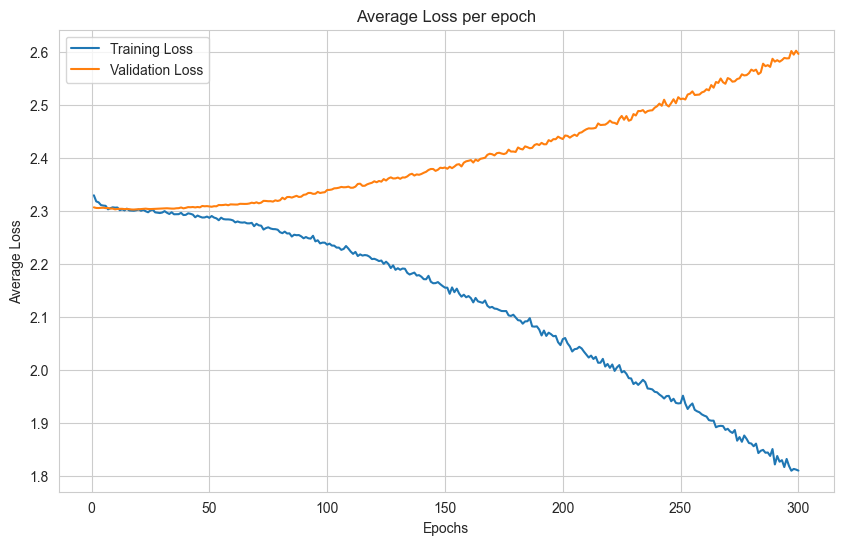

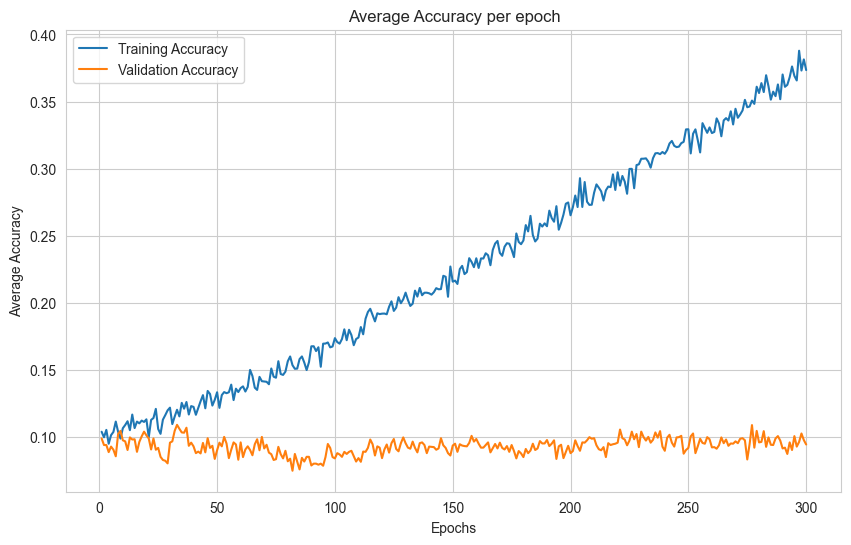

Overall Accuracy: 0.082


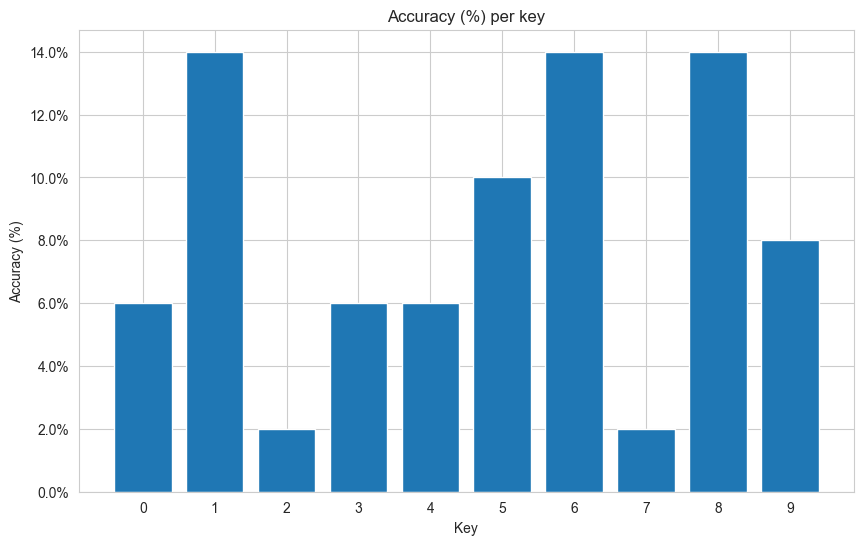

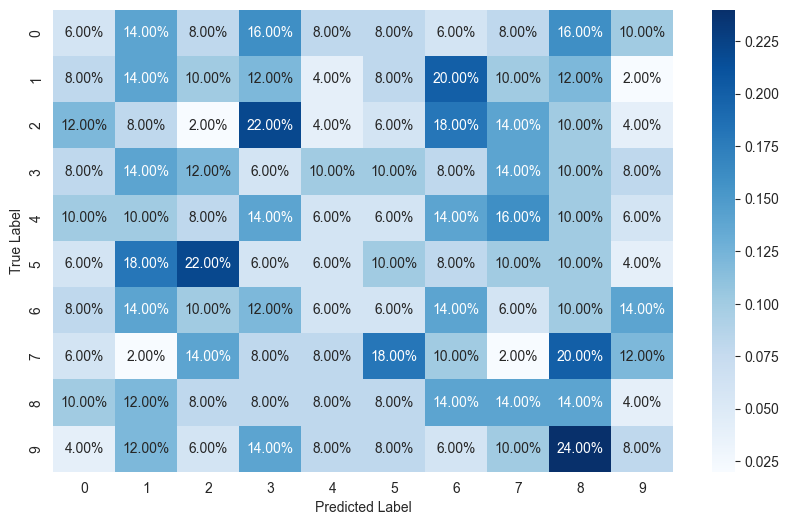

Accuracy for each key: 0: 6.0% 1: 14.0% 2: 2.0% 3: 6.0% 4: 6.0% 5: 10.0% 6: 14.0% 7: 2.0% 8: 14.0% 9: 8.0% 
              precision    recall  f1-score   support

           0       0.08      0.06      0.07        50
           1       0.12      0.14      0.13        50
           2       0.02      0.02      0.02        50
           3       0.05      0.06      0.06        50
           4       0.09      0.06      0.07        50
           5       0.11      0.10      0.11        50
           6       0.12      0.14      0.13        50
           7       0.02      0.02      0.02        50
           8       0.10      0.14      0.12        50
           9       0.11      0.08      0.09        50

    accuracy                           0.08       500
   macro avg       0.08      0.08      0.08       500
weighted avg       0.08      0.08      0.08       500

                    Model Parameters                    
Layer                    | Parameters
conv1d.weight            : 64 * 1 * 3 

In [12]:
def main():
    # setup parameters and load data
    batch_size = 64
    epochs = 300
    number_of_categories = 10
    
    X_train, X_val, X_test, y_train, y_val, y_test = importData()
    trainDataset = CSIDataset(X_train, y_train)
    valDataset = CSIDataset(X_val, y_val)
    
    trainLoader = DataLoader(trainDataset, shuffle=True, batch_size=batch_size)
    valLoader = DataLoader(valDataset, shuffle=True, batch_size=batch_size)

    model = CNN1D(number_of_categories)
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
    loss = nn.CrossEntropyLoss()
    
    if (os.path.isfile("model_final.pth")):
        model.load_state_dict(torch.load('model_final.pth'))
    else:
        train_loss_list, train_acc_list, eval_loss_list, eval_acc_list = train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss, (X_train.shape[0]//batch_size) + 1)
        # save the model
        torch.save(model.state_dict(), 'model_final.pth')
        plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs)
    
    # Simple check with test dataset
    model.eval()
    testDataset = CSIDataset(X_test, y_test)
    testLoader = DataLoader(testDataset, shuffle=True, batch_size=X_test.shape[0])
    test(model, testLoader, X_test.shape[0])
    
    print_model_parameters(model)
    
main()